The very first attampt to use QuantLib and BS model and generate a call price.
stock_price is stored in quote so we can change the value later.

In [17]:
import QuantLib as ql
import numpy as np

# option data
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(170.0)
strike_price = 150
volatility = 0.10 # the historical vols for a year
dividend_rate =  0.002
risk_free_rate = 0.003
option_type = ql.Option.Call

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(27, 10, 2019)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


Analytic Black-Scholes calculation:

In [19]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
delta = european_option.delta()
gamma = european_option.gamma()
vega = european_option.vega()
rho = european_option.rho()

print("The theoretical price is ", bs_price)
print("The delta is ", delta)
print("The gamma is ", gamma)
print("The vega is ", vega)
print("The rho is ", rho)

The theoretical price is  20.912114216635807
The delta is  0.9022541582733737
The gamma is  0.009938484700038275
The vega is  29.03698484648708
The rho is  133.9228306919182


In [4]:
#prepare for plotting
xs_bs = np.linspace(100, 200, 400)
ys_bs = []
for x in xs_bs:
    stock_price.setValue(x)
    ys_bs.append(european_option.NPV())

Instead of using analytic Black-Scholes formula, we can use Monte-Carlo simulation.

In [5]:
stock_price.setValue(170)
engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                      timeSteps=20,
                                      requiredSamples=250000)
european_option.setPricingEngine(engine)
bs_price = european_option.NPV()
error = european_option.errorEstimate()
print("The monte carlo theoretical price is ", bs_price)
print("The monte carlo error is ", error)

The monte carlo theoretical price is  20.916482907688053
The monte carlo error is  0.03161661238051468


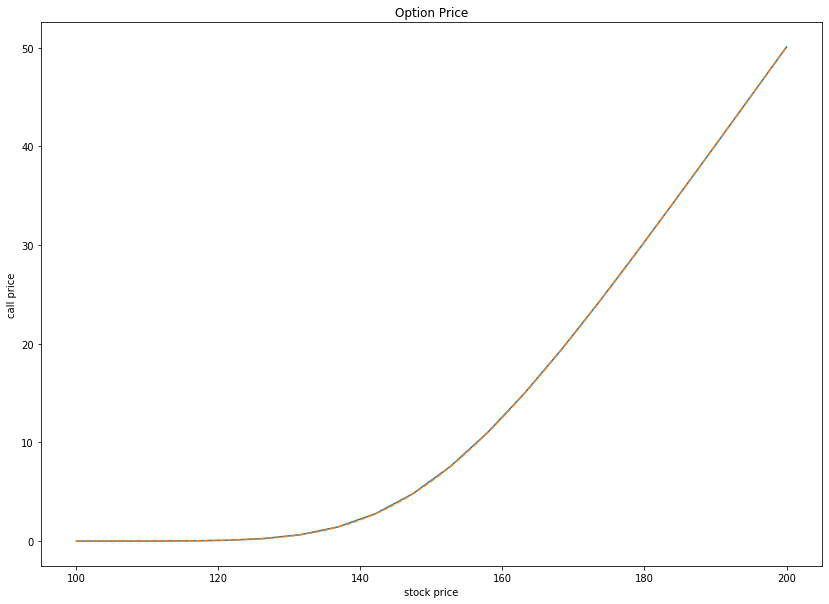

In [20]:
%matplotlib inline
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

xs = np.linspace(100, 200, 20)
ys = []
for x in xs:
    stock_price.setValue(x)
    ys.append(european_option.NPV())
    
plt.figure(figsize=(14,10))
plt.plot(xs, ys)
plt.plot(xs_bs, ys_bs, linestyle='dashed')
plt.xlabel('stock price') 
plt.ylabel('call price') 
plt.title('Option Price') 
plt.show() 


An Option Class which stores all the options info; return BS model call price; return the wanted data set for training purpose.

In [7]:
class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


Functions to help in converting and auto-generate specific numbers of options sample data for training.

In [8]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,10,30)
    end_maturity = datetime.datetime(2022,10,30)

    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0.001, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.BSM_price())
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


In [9]:
n = 300000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
print(df)
print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = train['call_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = test['call_price'].values

        stock_price  strike_price  maturity  devidends  volatility  \
0          0.977273           308  2.287671   0.001474    0.625849   
1          0.484783           460  2.326027   0.000925    0.141906   
2          0.186469           606  2.046575   0.001420    0.822202   
3          0.880000           225  2.712329   0.002862    0.466029   
4          1.068884           421  2.561644   0.001362    0.870905   
...             ...           ...       ...        ...         ...   
299995     1.950980           204  0.723288   0.001219    0.609665   
299996     1.110825           388  0.479452   0.002466    0.556509   
299997     0.726667           150  1.523288   0.000324    0.878576   
299998     1.152493           341  0.860274   0.001978    0.833239   
299999     0.598326           239  1.915068   0.000972    0.793259   

        risk_free_rate  call_price  
0             0.001673    0.347566  
1             0.001467    0.000016  
2             0.001809    0.015463  
3          

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
from tensorflow import squeeze

# problem is not because of my custom activation function, it's because of exponential activation not applied in this case

nodes = 100
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('exponential'))
          
model.compile(loss='mse',optimizer='rmsprop')

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Using TensorFlow backend.


Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 5s - loss: nan - val_loss: nan
Epoch 2/10
 - 5s - loss: nan - val_loss: nan
Epoch 3/10
 - 5s - loss: nan - val_loss: nan
Epoch 4/10
 - 5s - loss: nan - val_loss: nan
Epoch 5/10
 - 5s - loss: nan - val_loss: nan
Epoch 6/10
 - 5s - loss: nan - val_loss: nan
Epoch 7/10
 - 5s - loss: nan - val_loss: nan
Epoch 8/10
 - 5s - loss: nan - val_loss: nan
Epoch 9/10
 - 5s - loss: nan - val_loss: nan
Epoch 10/10
 - 5s - loss: nan - val_loss: nan
The mean squared error (MSE) for the test data set is: nan


A modified NN which gives really good results. Haven't adapted to their scaling method.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=6,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]

model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)

y_test_hat = model.predict(X_test)


Train on 192000 samples, validate on 48000 samples
Epoch 1/30
 - 5s - loss: 0.3909 - val_loss: 0.0174
Epoch 2/30
 - 5s - loss: 0.0313 - val_loss: 0.0044
Epoch 3/30
 - 5s - loss: 0.0182 - val_loss: 0.0038
Epoch 4/30
 - 5s - loss: 0.0142 - val_loss: 0.0354
Epoch 00004: early stopping
The mean squared error (MSE) for the test data set is: 0.03569148866515825


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

model = Sequential()

nodes = 100
model.add(Dense(nodes,input_dim=6))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train, y_train, epochs=10, validation_split=0.1,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)
print(y_train_hat)

y_test_hat = model.predict(X_test)
print(y_test_hat)

Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 8s - loss: 3.0226 - val_loss: 0.2396
Epoch 2/10
 - 8s - loss: 0.7956 - val_loss: 0.1433
Epoch 3/10
 - 8s - loss: 0.6460 - val_loss: 0.1228
Epoch 4/10
 - 8s - loss: 0.5946 - val_loss: 0.8466
Epoch 5/10
 - 8s - loss: 0.5957 - val_loss: 0.0963
Epoch 6/10
 - 10s - loss: 0.6316 - val_loss: 0.1455
Epoch 7/10
 - 9s - loss: 0.6061 - val_loss: 0.1099
Epoch 8/10
 - 9s - loss: 0.6695 - val_loss: 0.1502
Epoch 9/10
 - 11s - loss: 0.6124 - val_loss: 0.1191
Epoch 10/10
 - 9s - loss: 0.5724 - val_loss: 0.1649
The mean squared error (MSE) for the test data set is: 0.17634169648157474
[[0.26303947]
 [0.16103673]
 [0.16103673]
 ...
 [1.9478593 ]
 [2.1565359 ]
 [0.16103673]]
[[0.597736  ]
 [0.16103673]
 [0.16103673]
 ...
 [0.16103673]
 [0.16103673]
 [0.16103673]]


Mean Squared Error:       0.17563647773671415
Root Mean Squared Error:  0.4190900592196314
Mean Absolute Error:      0.20469113474342393
Mean Percent Error:       0.2906478504280663


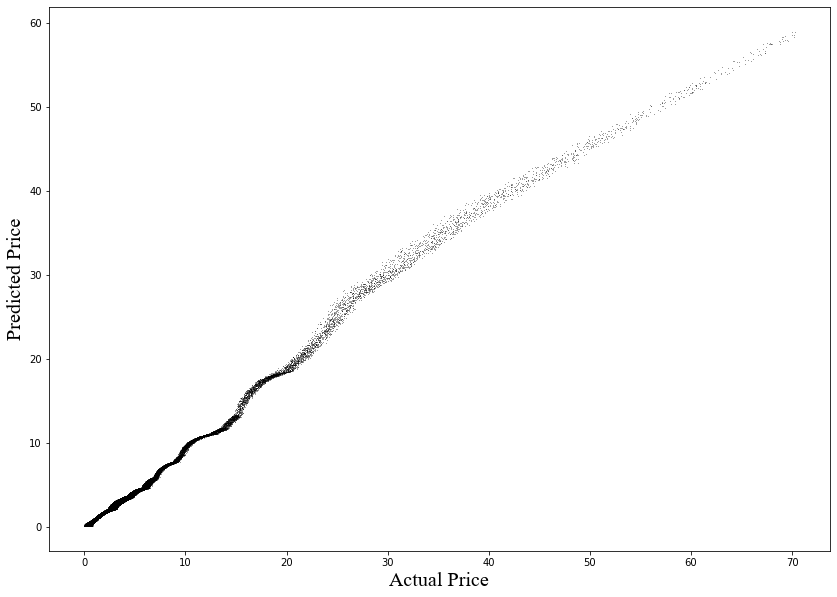

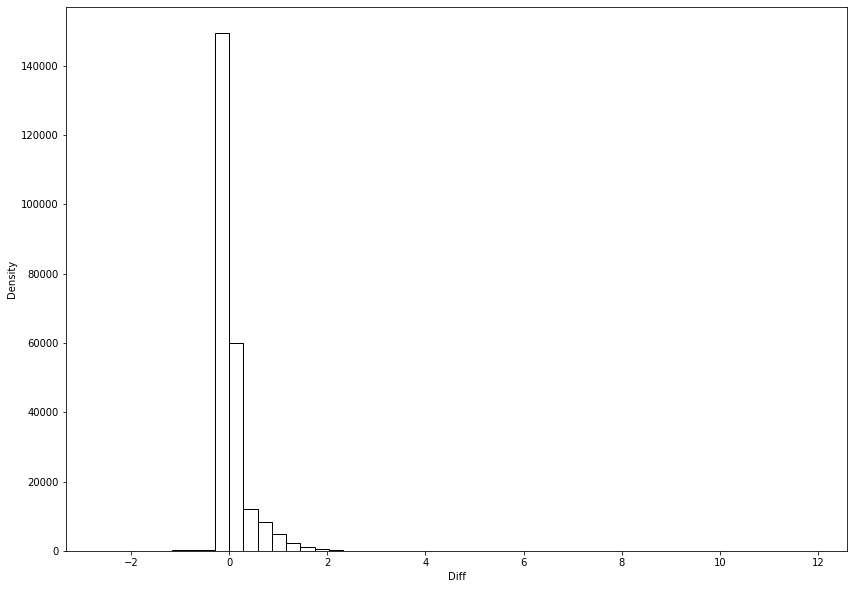

In [13]:
from statistics import *
from math import sqrt
import matplotlib as mpl
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = squeeze(y_train_hat).numpy()
CheckAccuracy(y_train, y_train_hat)

Mean Squared Error:       0.176341697350564
Root Mean Squared Error:  0.4199305863479868
Mean Absolute Error:      0.20436393331688324
Mean Percent Error:       0.29523180805315064


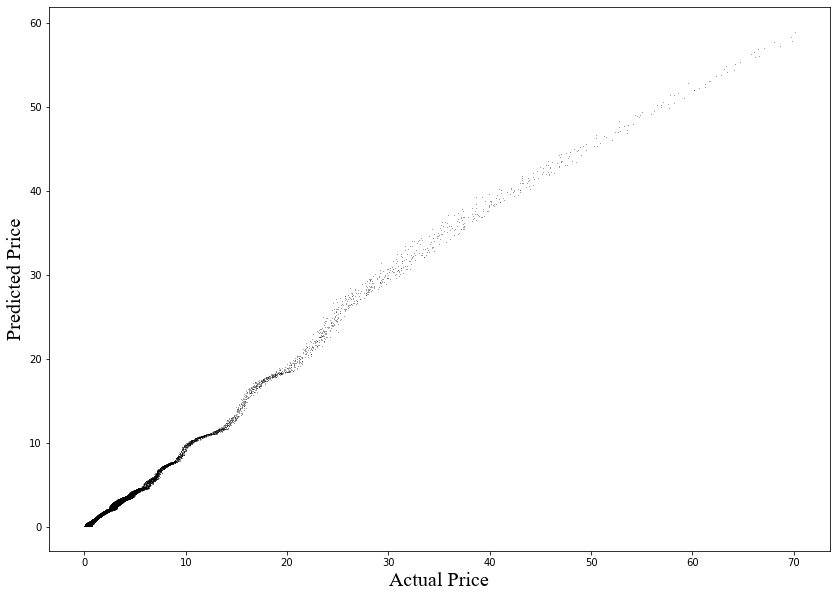

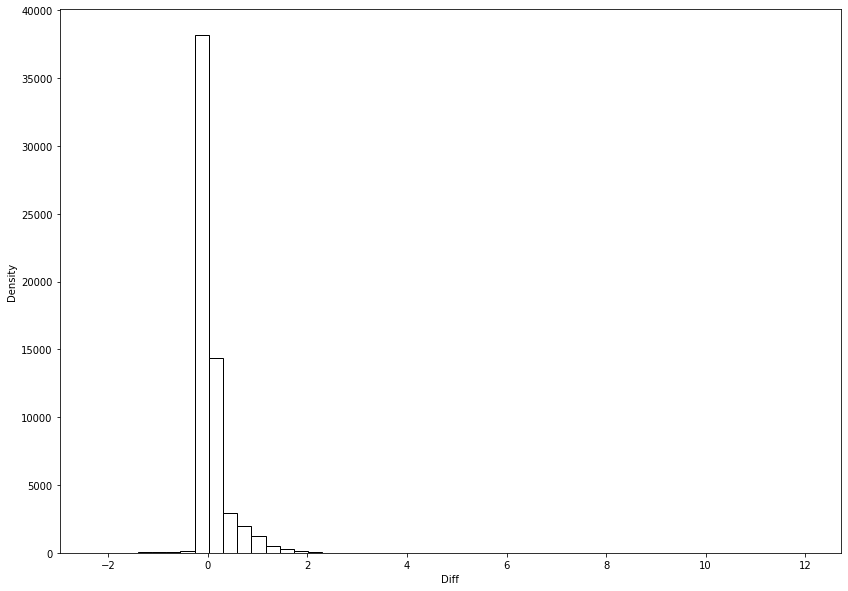

In [14]:
y_test_hat = squeeze(y_test_hat).numpy()
CheckAccuracy(y_test, y_test_hat)